In [9]:
# The NN aims to reconstruct both energy and mass of primary CR particles
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
import pandas as pd

In [10]:
# get labels and features, then divide them into train and test 
n_features = 4
trial = False
datadir = 'D:\\LHAASO\\LHAASO\\Data\\Simulation\\R_Copy\\'
pars = ['Proton','He','CNO','MgAlSi','Fe']
for par in pars:
    file = datadir+'All_events_'+par+'.npy' # glob is only used for a list of files, not single one.
    if par == 'Proton':
        cols = np.load(file,allow_pickle=True)
    else:
        f = np.load(file,allow_pickle=True)
        cols = np.row_stack((cols,f))
if trial == True:
    cols = cols[:1000,]
print(cols.shape)
indx = np.arange(len(cols))
np.random.shuffle(indx)
cols = cols[indx]
#print(cols[1,:])
labels = np.column_stack((cols[:,0],cols[:,5]))
features = np.column_stack((cols[:,1],cols[:,2],cols[:,3],cols[:,4]))
X = features
y = labels
#print(ene_true)
#print(mass_true)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

ene_true = y_test[:,0]
mass_true = y_test[:,1]

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# switch numpy arrays into tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

(3083083, 6)


In [11]:
# Build the neural network and define necessary functions
class Net(nn.Module):
    def __init__(self,n_features):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(n_features,4) #4
        self.fc2 = nn.Linear(4,3) # 4-3
        self.fc3 = nn.Linear(3,2) # 3-2
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# To calculate the root mean square error
def RMSE(x,y):
    for i in range(len(x)):
        if i==0:
            err = (x[i]-y[i])**2
        else:
            err += (x[i]-y[i])**2
    return err/len(x)

net = Net(n_features)
# define the optimizer and the loss function
lossf = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(net.parameters(),lr = 0.001)


In [12]:
# Use GPU to calculate, map all the data to GPU
print('USE GPU' if torch.cuda.is_available() else 'USE CPU')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
lossf = lossf.to(device)

USE GPU


epoch:0
Loss:14.907696723937988
epoch:1
Loss:14.896160125732422
epoch:2
Loss:14.88470458984375
epoch:3
Loss:14.873330116271973
epoch:4
Loss:14.862035751342773
epoch:5
Loss:14.850822448730469
epoch:6
Loss:14.839694023132324
epoch:7
Loss:14.82864761352539
epoch:8
Loss:14.817686080932617
epoch:9
Loss:14.806808471679688
epoch:10
Loss:14.796014785766602
epoch:11
Loss:14.785307884216309
epoch:12
Loss:14.774683952331543
epoch:13
Loss:14.764145851135254
epoch:14
Loss:14.753693580627441
epoch:15
Loss:14.743325233459473
epoch:16
Loss:14.733043670654297
epoch:17
Loss:14.722846031188965
epoch:18
Loss:14.71273422241211
epoch:19
Loss:14.702703475952148
epoch:20
Loss:14.692758560180664
epoch:21
Loss:14.682897567749023
epoch:22
Loss:14.673118591308594
epoch:23
Loss:14.663421630859375
epoch:24
Loss:14.653806686401367
epoch:25
Loss:14.644272804260254
epoch:26
Loss:14.634817123413086
epoch:27
Loss:14.625441551208496
epoch:28
Loss:14.616144180297852
epoch:29
Loss:14.606921195983887
epoch:30
Loss:14.597772

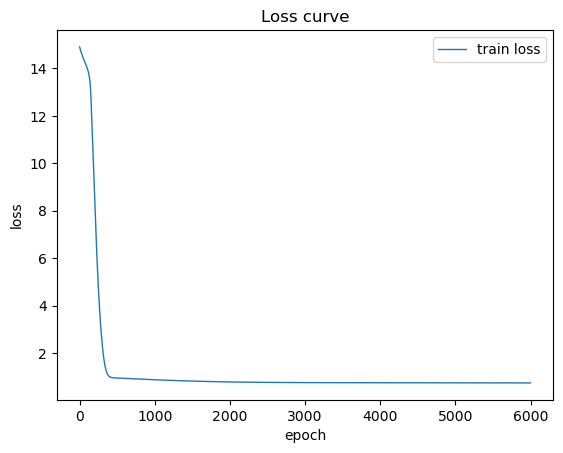

In [13]:
# Train the model and get the loss curve
train_loss = []
for epoch in range(6000):
    print('epoch:%s'%epoch)
    y_pred = net(X_train)
    loss = lossf(y_pred,y_train)
    train_loss.append(loss.item())
    print('Loss:%s'%loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plot the epoch-curve
epoches = range(len(train_loss))
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoches,train_loss,linewidth = 1,linestyle = 'solid',label = 'train loss')
plt.legend()
plt.title('Loss curve')
plt.show()

0.04521803717574324
1.4253183363737116


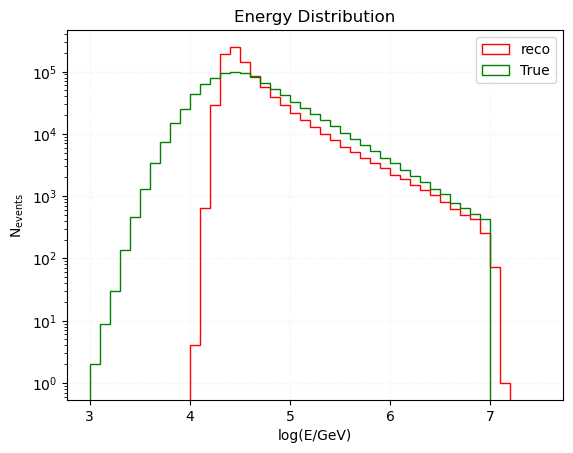

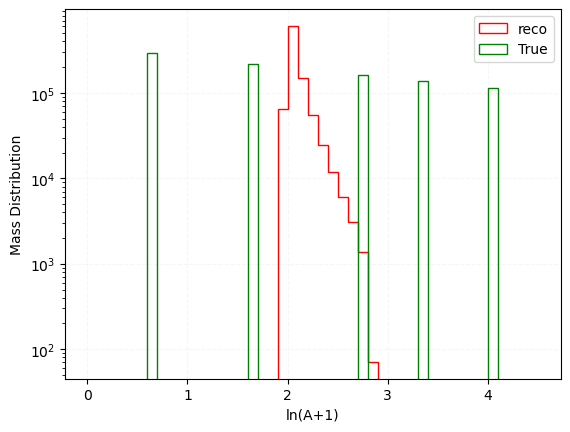

In [14]:
y_pred_test = net(X_test)
y_pred_test1 = y_pred_test.cpu().detach().numpy()
ene_reco = y_pred_test1[:,0]
mass_reco = y_pred_test1[:,1]
#print(ene_reco) 
#print(mass_reco)
#print(ene_true)
#print(mass_true)
print(RMSE(ene_true,ene_reco))
print(RMSE(mass_true,mass_reco))

# Plot the energy histogram
logEbins = np.linspace(3,7.5,46) # 46=45+1, arrange 46 points to make 45 divisions 
plt.figure()
plt.hist(ene_reco,bins=logEbins,histtype='step',color='r', label='reco')
plt.hist(ene_true,bins=logEbins,histtype='step',color='g', label='True')
plt.xlabel('log(E/GeV)')
plt.ylabel(r'N$_{\rm events}$')
plt.title("Energy Distribution")
plt.yscale('log')
plt.legend()
plt.grid(ls='--', alpha=0.1)
plt.show()

# mass distribution
logMbins = np.linspace(0,4.5,46)
tmass_hist,bins1 = np.histogram(mass_true,bins=logMbins)
rmass_hist,bins2 = np.histogram(mass_reco,bins=logMbins)
plt.figure()
plt.hist(mass_reco,bins=logMbins,histtype='step',color='r', label='reco')
plt.hist(mass_true,bins=logMbins,histtype='step',color='g', label='True')
plt.xlabel('ln(A+1)')
plt.ylabel('Mass Distribution')
plt.yscale('log') # set y-axis to the logstyle
plt.legend()
plt.grid(ls = '--',alpha = 0.1)
plt.show()

[1.609438 1.609438 1.609438 ... 1.609438 1.609438 1.609438]


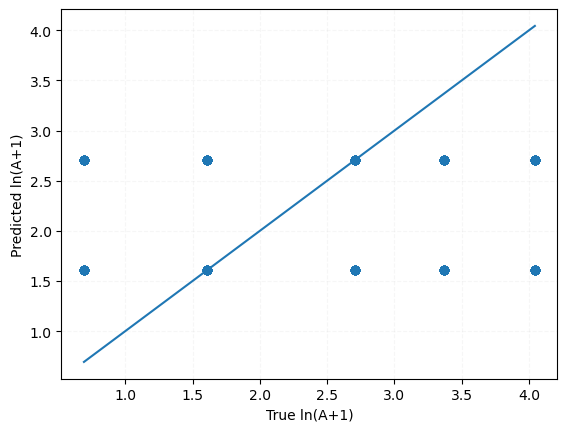

In [15]:
# Classification
reco_copy = mass_reco
# get the reconstructed values
for i in range(0,len(mass_reco)):
    if mass_reco[i]<(np.log(2)+np.log(5))/2:
        reco_copy[i] = np.log(2)
    elif mass_reco[i]>=(np.log(2)+np.log(5))/2 and mass_reco[i]<(np.log(5)+np.log(15))/2:
        reco_copy[i] = np.log(5)
    elif mass_reco[i]>=(np.log(5)+np.log(15))/2 and mass_reco[i]<(np.log(15)+np.log(29))/2:
        reco_copy[i] = np.log(15)
    elif mass_reco[i]>=(np.log(15)+np.log(29))/2 and mass_reco[i]<(np.log(29)+np.log(57))/2:
        reco_copy[i] = np.log(29)
    elif mass_reco[i]>=(np.log(29)+np.log(57))/2:
        reco_copy[i] = np.log(57)
x = [np.log(2),np.log(5),np.log(15),np.log(29),np.log(57)]
#print(x)
print(reco_copy)
y_x = x
plt.figure()
plt.scatter(mass_true,reco_copy,alpha=0.1)
plt.plot(x,y_x)
plt.xlabel('True ln(A+1)')
plt.ylabel('Predicted ln(A+1)')
#plt.yscale('log') # set y-axis to the logstyle
plt.grid(ls = '--',alpha = 0.1)
plt.show()

[1. 1. 1. ... 1. 1. 1.]
[0. 0. 1. ... 0. 2. 0.]
[[     0 257812  33573      0      0]
 [     0 186445  30823      0      0]
 [     0 136412  27859      0      0]
 [     0 111870  26570      0      0]
 [     0  88714  24847      0      0]]
[291385 217268 164271 138440 113561]
[     0 257812  33573      0      0]
[0.        0.8847813 0.1152187 0.        0.       ]
[     0 186445  30823      0      0]
[0.         0.85813373 0.14186627 0.         0.        ]
[     0 136412  27859      0      0]
[0.         0.83040829 0.16959171 0.         0.        ]
[     0 111870  26570      0      0]
[0.        0.8080757 0.1919243 0.        0.       ]
[    0 88714 24847     0     0]
[0.         0.78120129 0.21879871 0.         0.        ]


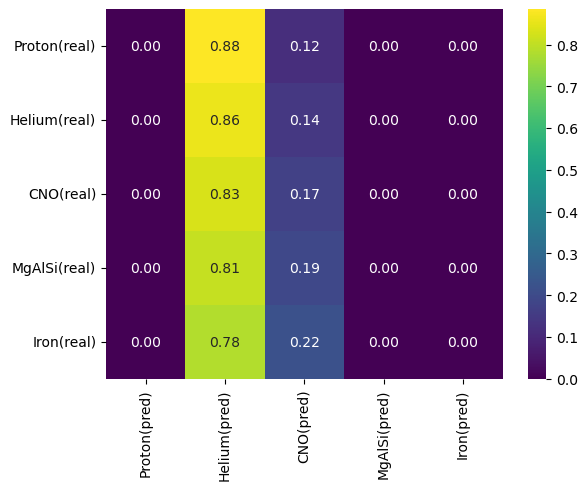

In [16]:
# confusion matrix
# give labels (0,1,2,3,4) to plot sns.heatmap
reco_test = np.zeros(len(mass_reco))
for i in range(0,len(mass_reco)):
    if mass_reco[i]<(np.log(2)+np.log(5))/2:
        reco_test[i] = 0
    elif mass_reco[i]>=(np.log(2)+np.log(5))/2 and mass_reco[i]<(np.log(5)+np.log(15))/2:
        reco_test[i] = 1
    elif mass_reco[i]>=(np.log(5)+np.log(15))/2 and mass_reco[i]<(np.log(15)+np.log(29))/2:
        reco_test[i] = 2
    elif mass_reco[i]>=(np.log(15)+np.log(29))/2 and mass_reco[i]<(np.log(29)+np.log(57))/2:
        reco_test[i] = 3
    elif mass_reco[i]>=(np.log(29)+np.log(57))/2:
        reco_test[i] = 4
print(reco_test)

# give labels to the real data set
true_test = np.zeros(len(mass_true))
for i in range(0,len(mass_true)):
    if mass_true[i] == np.log(2):
        true_test[i]=0
    elif mass_true[i]==np.log(5):
        true_test[i]=1
    elif mass_true[i]==np.log(15):
        true_test[i]=2
    elif mass_true[i]==np.log(29):
        true_test[i]=3
    elif mass_true[i]== np.log(57):
        true_test[i]=4
print(true_test)

# Plot the heatmap
con_metrix = metrics.confusion_matrix(true_test,reco_test)
print(con_metrix)

#calculate rates
tot_real = con_metrix.sum(axis=1)
rate_metrix = np.zeros((5,5))
print(tot_real)
for i in range(0,5):
    print(con_metrix[i])
    rate_metrix[i]=con_metrix[i]/float(tot_real[i])
    print(rate_metrix[i])

# plot the confusion matrix
rm = pd.DataFrame(rate_metrix,columns=['Proton(pred)','Helium(pred)','CNO(pred)','MgAlSi(pred)','Iron(pred)'],
                          index=['Proton(real)','Helium(real)','CNO(real)','MgAlSi(real)','Iron(real)'])
sns.heatmap(rm,cmap="viridis",fmt=".2f",annot=True)
plt.show()
